# Automated Essay Checking

** Each cell contains a description in the beginnning followed the by code that executes the task in the description of the cell.**

**Begin: Importing data structures to hold the data**  

Importing NumPy and Pandas, these data structures will hold the training and testing data.
The total number of columns and length of the data-set is been printed at the end of the code execution.

In [3]:
# Import libraries and data.
import numpy as np
import pandas as pd

essay_data = pd.read_csv("domain1.csv")
print(essay_data.columns)
print("Length of the data=",len(essay_data))


Index([u'essay_id', u'essay_set', u'essay', u'rater1_domain1',
       u'rater2_domain1', u'rater3_domain1', u'domain1_score'],
      dtype='object')
('Length of the data=', 1783)


In [4]:
#Preprocessing, extracting the features.
def somefunc(X,target_col):
    #feature_columns = ["essay","word_count","sentence_count","wrong_words","spelling_mistakes","no_of_domain_words","word_to_sent_ratio","num_of_characters",'NN','NNP','VBZ','NNPS','NNS','IN','PRP','VB','JJ','VBP','VBG',"target"]
    feature_columns = ["essay","word_count","long_word_count","avg_word_length_per_essay","wrong_words","no_of_domain_words","word_to_sent_ratio","num_of_characters","sentence_count","noun_count","verb_count","comma_count","punctuation_count","adjective_count","adverb_count","quotation_mark_count","spelling_mistakes","target"]
    feature_pd = pd.DataFrame(index = X.index, columns = feature_columns)
    feature_pd['essay'] = X['essay']
    feature_pd['target'] = X[target_col]
    return feature_pd
feature_data = somefunc(essay_data,'domain1_score')


In [5]:
from sklearn.model_selection import train_test_split

feature_cols = list(feature_data.columns[:-1])
X_all = feature_data[feature_cols]
y_all = feature_data['target'] #domain1_score is equal to sum of rater_domain1 and rater_domain2, so that columns are not needed


In [6]:
import nltk
import re
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
import grammar_check
from collections import Counter
import textmining
from time import time

def featureSet2(X): #X would be X_train and X_test
    #WordCount
    for index,row in X.iterrows():
        
        text = unicode(row['essay'],errors='ignore') 
        text = " ".join(filter(lambda x:x[0]!='@', text.split())) #To remove proper nouns tagged in the data-set which may result into false positives during POS tagging.
        
        punctuation = ['.','?', '!', ':', ';']
        #Comma count
        comma_count = text.count(',')
        row['comma_count'] = comma_count
        
        #Punctuation count
        punctuation_count = 0
        for punct in punctuation:
            punctuation_count += text.count(punct)
        row['punctuation_count'] = punctuation_count
        
        #Quotation marks count
        quotation_mark_count = text.count('"')
        quotation_mark_count += text.count("'")
        row['quotation_mark_count'] = quotation_mark_count
        
        #Add the sentence count
               
        tokenized_essay = nltk.sent_tokenize(text)
        sent_count = len(tokenized_essay)
        row['sentence_count'] = sent_count
        
        #Add word count after removing the stop words.
        words = nltk.word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}']) # remove it if you need punctuation 
        
        for word in words:
            if word in stop_words:
                words.remove(word)
        word_count = len(words)
        
        row['word_count'] = word_count
        
        #Long word count
        long_word_count = 0
        total_word_length = 0
        for word in words:
            total_word_length += len(word)
            if len(word) > 6:
                long_word_count +=1
        row['long_word_count'] = long_word_count
        
        #Average word length per essay
        row['avg_word_length_per_essay'] = round((total_word_length/float(len(words))),2)
        
        
        tool = grammar_check.LanguageTool('en-US')
        matches = tool.check(text)
        row['spelling_mistakes'] = len(matches)
           
        #POS TAGS
        count= Counter([j for i,j in nltk.pos_tag(words)])
               
        row['noun_count'] = count['NN'] + count['NNS'] + count['NNPS'] + count['NNP']
        row['verb_count'] = count['VB'] + count['VBG'] + count['VBP'] + count['VBN'] + count['VBZ']
        row['adjective_count'] = count['JJ'] + count['JJR'] 
        row['adverb_count'] = count['RB'] + count['RBR'] + count['RBS']
        
        #No_of_domain_words and wrong words after removing the stop words and punctuations from the essay.
        cnt = 0
        wrong_word_count = 0
        for word in words:
            if wn.synsets(word):
                cnt += 1
            else:
                wrong_word_count += 1
        row['no_of_domain_words'] = cnt
        row['wrong_words'] = wrong_word_count        
        
        #Word to sentence ratio
        row['word_to_sent_ratio'] = round(float(word_count/float(sent_count)),2)
        
        #Number of characters
        row['num_of_characters'] = nltk.FreqDist(text).N()
        
        #Debugging
        if index%10==0:
            print "made features for rows with index upto ",index
        
print "Done"

Done


In [7]:
#Generate the feature set.
def GenerateFeatures(X):
    start = time()
    featureSet2(X)
    end = time()
    print ("Generated the features for the entire data-set in {:.4f} minutes".format((end - start)/60.0))

#temp=X_all[:200]
GenerateFeatures(X_all)
print "Done"

made features for rows with index upto  0
made features for rows with index upto  10
made features for rows with index upto  20
made features for rows with index upto  30
made features for rows with index upto  40
made features for rows with index upto  50
made features for rows with index upto  60
made features for rows with index upto  70
made features for rows with index upto  80
made features for rows with index upto  90
made features for rows with index upto  100
made features for rows with index upto  110
made features for rows with index upto  120
made features for rows with index upto  130
made features for rows with index upto  140
made features for rows with index upto  150
made features for rows with index upto  160
made features for rows with index upto  170
made features for rows with index upto  180
made features for rows with index upto  190
made features for rows with index upto  200
made features for rows with index upto  210
made features for rows with index upto  220

In [8]:
# Save the features generated to a .csv file in case of failure or recovery purpose.
X_all.to_csv('features_set_1.csv', sep='\t')

describe_the_data = X_all.drop('essay',axis = 1)
describe_the_data.head()

,word_count,long_word_count,avg_word_length_per_essay,wrong_words,no_of_domain_words,word_to_sent_ratio,num_of_characters,sentence_count,noun_count,verb_count,comma_count,punctuation_count,adjective_count,adverb_count,quotation_mark_count,spelling_mistakes
0,236,54,4.83,67,169,14.75,1819,16,78,51,15,17,24,10,4,0
1,281,76,4.93,56,225,16.53,2205,17,94,66,11,17,18,17,3,1
2,188,51,5.01,34,154,13.43,1482,14,68,43,8,14,17,10,4,6
3,346,109,5.38,76,270,13.31,2817,26,134,64,12,26,38,21,5,14
4,318,81,4.99,88,230,10.6,2533,30,107,57,12,30,21,24,5,3


In [9]:
#Fitting, predicting and calculating error. 
#Using LinearRegression, 5 fold cross validation and quadratic kappa as an error metric.
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.linear_model import LinearRegression
from metrics import kappa

def Evaluate(feature_list):
    model = LinearRegression()

    #Simple K-Fold cross validation. 5 folds.
    cv = cross_validation.KFold(len(X_all), n_folds=5,shuffle=True)
    results = []
    
    for traincv, testcv in cv:
            X_test, X_train, y_test, y_train = X_all.ix[testcv], X_all.ix[traincv], y_all.ix[testcv], y_all.ix[traincv]

            #final_train_data = X_train.drop('essay',axis = 1)
            #final_test_data = X_test.drop('essay',axis = 1)
            
            final_train_data = X_train[feature_list]
            final_test_data = X_test[feature_list]
            
            model.fit(final_train_data,y_train)
            start = time()
            y_pred = model.predict(final_test_data)
            end = time()

            #print ("Made predictions in {:.4f} seconds.".format(end - start))
            result = kappa(y_test.values,np.around(y_pred,decimals=2),weights='quadratic')
            results.append(result)
            #print y_test,np.around(y_pred,decimals=2)
            X_test_list = [i for i in range(len(X_test))]
            plt.scatter(X_test_list,y_test.values,color='black')
            plt.scatter(X_test_list,np.around(y_pred,decimals=2),color='blue')
            #print len(X_test),len(y_test),len(y_pred)
            #probas = model.fit(train[traincv], target[traincv]).predict_proba(train[testcv])
            

    #print "Results: " + str( np.array(results).mean() )
    return str(np.array(results).mean())


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
feature_columns = ["word_count","long_word_count","avg_word_length_per_essay","wrong_words","no_of_domain_words","word_to_sent_ratio","num_of_characters","sentence_count","noun_count","verb_count","comma_count","punctuation_count","adjective_count","adverb_count","quotation_mark_count","spelling_mistakes"]
feature_dict = {}
for i in feature_columns:
    feature_dict[i] = 0
Evaluate(feature_columns)

/home/alphamike/.local/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


'0.685942374656'

In [11]:
for f in feature_columns:
    score = Evaluate([f])
    feature_dict[f] = round(float(score)*100,4)
feature_dict

{'adjective_count': 53.4764,
 'adverb_count': 44.407,
 'avg_word_length_per_essay': 15.9346,
 'comma_count': 45.6213,
 'long_word_count': 63.8797,
 'no_of_domain_words': 62.0602,
 'noun_count': 59.3343,
 'num_of_characters': 62.8461,
 'punctuation_count': 51.7592,
 'quotation_mark_count': 19.5724,
 'sentence_count': 52.7083,
 'spelling_mistakes': 18.2192,
 'verb_count': 49.8331,
 'word_count': 61.5948,
 'word_to_sent_ratio': 9.058,
 'wrong_words': 47.3121}

# Visualizing single-feature kappa scores


		Index	 Feature
		| 0 |	| long_word_count |
		--------------------------------
		| 1 |	| num_of_characters |
		--------------------------------
		| 2 |	| no_of_domain_words |
		--------------------------------
		| 3 |	| word_count |
		--------------------------------
		| 4 |	| noun_count |
		--------------------------------
		| 5 |	| adjective_count |
		--------------------------------
		| 6 |	| sentence_count |
		--------------------------------
		| 7 |	| punctuation_count |
		--------------------------------
		| 8 |	| verb_count |
		--------------------------------
		| 9 |	| wrong_words |
		--------------------------------
		| 10 |	| comma_count |
		--------------------------------
		| 11 |	| adverb_count |
		--------------------------------
		| 12 |	| quotation_mark_count |
		--------------------------------
		| 13 |	| spelling_mistakes |
		--------------------------------
		| 14 |	| avg_word_length_per_essay |
		--------------------------------
		| 15 |	| word_to_sent_ratio |
		--

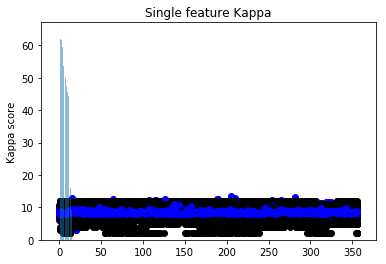

In [12]:
#Single feature Kappa
import operator
sorted_feature_list = sorted(feature_dict.items(), key=operator.itemgetter(1),reverse=True)
#sorted_feature_list

print "\t\tIndex\t Feature"
for x in range(len(sorted_feature_list)):
    print "\t\t|",x,"|\t|",sorted_feature_list[x][0],"|"
    print "\t\t--------------------------------"

objects = [x[1] for x in sorted_feature_list]
y_pos = np.arange(len(objects))
plt.bar(y_pos, objects, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('Kappa score')
plt.title('Single feature Kappa')
plt.show()

Index   Forward Feature list


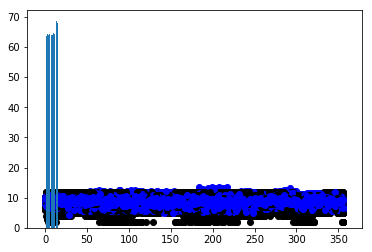

In [13]:
#Forward feature selection.
sorted_f = [i[0] for i in sorted_feature_list]
objects = []
results = []
for i in range(1,len(sorted_f)+1):
    forward_feature_list = sorted_f[:i]
    round(float(score)*100,4)
    result = round(float(Evaluate(forward_feature_list))*100,4)
    results.append(result)
    objects.append(forward_feature_list)
     
print "Index   Forward Feature list"
#for x in range(len(objects)):
    #print x,"  ",objects[x]
    #print "--------------------------------------------------"
        
y_pos = np.arange(len(objects))
plt.bar(y_pos,results)
plt.show()

**Manually selecting best performing feature-set from the results obtained through forward feature selection**

Selected the features whose inclusion resulted in an increase in the Kappa-Score, according to the values and the graphs, the indexes of selected feature are {0,1,2,3,5,8,10,11,13,14,15}

In [14]:
selected_indexes  = [0,1,2,3,5,8,10,11,13,14,15] #Do not delete
selected_features = [sorted_f[i] for i in selected_indexes]
result = Evaluate(selected_features)

print Evaluate(selected_features)
print Evaluate(sorted_f)
selected_features


0.686540374848
0.688046122436


['long_word_count',
 'num_of_characters',
 'no_of_domain_words',
 'word_count',
 'adjective_count',
 'verb_count',
 'comma_count',
 'adverb_count',
 'spelling_mistakes',
 'avg_word_length_per_essay',
 'word_to_sent_ratio']

# Data exploration

The plots below allows us to view the underlying trends within the data. The plots visualize how the 11 selected features through forward feature selection impact the grade of an essay.

In [15]:
def plots(x,y,xlabel,title,ax,color='b'):
    ax.scatter(x,y,color = color)
    ax.set_ylabel('Grade')
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    
    

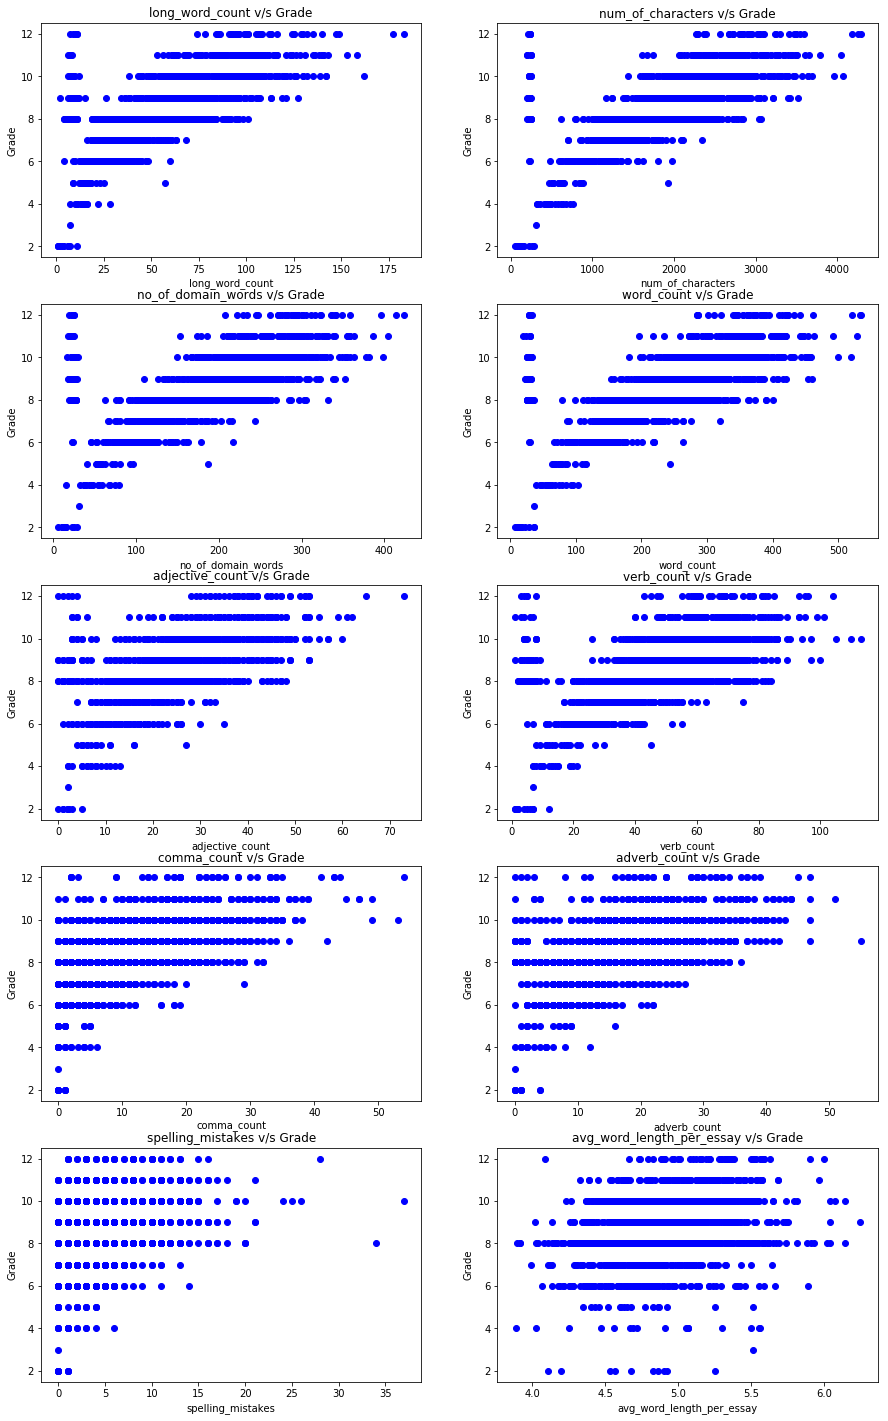

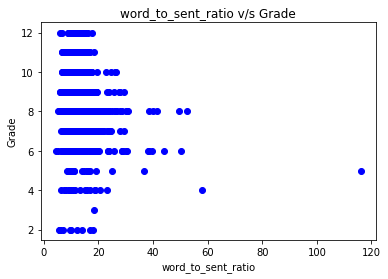

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6),(ax7, ax8),(ax9, ax10)) = plt.subplots(5, 2, figsize=(15, 25))
axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]
for i in range(len(selected_features)-1):
    plots(X_all[selected_features[i]],y_all,selected_features[i],selected_features[i] +" v/s Grade",axs[i])
    
fig.savefig('Essay1Features.png', bbox_inches = "tight")
  
fig, ax = plt.subplots()
plots(X_all['word_to_sent_ratio'],y_all,'word_to_sent_ratio','word_to_sent_ratio v/s Grade',ax)

# Observation

As expected, we were able to see general trends between the sentence structure of an essay and the grade it received. Noteably, we see that it is not uncommon to see essays with a large number of spelling mistakes receive a high grade. One could make the assumption that techonology's (Word's Spell Check) influence on writing has made it less imperitive for students to spell correctly. It seems as though the message carries more weight than specific errors in the essay.

In [ ]:
#Redundant code
'''
#Training testing using train_test_split

num_train = 1450

# Set the number of testing points
num_test = X_all.shape[0] - num_train


#Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=num_train,random_state=42)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))
print type(X_test)
print type(y_test)
y_test.name = "scores"


def termdocumentmatrix():
    # Initialize class to create term-document matrix
    tdm = textmining.TermDocumentMatrix()
    # Add the documents
    for index,row in essay_data.iterrows():
        tdm.add_doc(row['essay'])
    # Write out the matrix to a csv file. Note that setting cutoff=2 means
    # that words which appear in 1 or more documents will be included in
    # the output (i.e. every word will appear in the output). The default
    # for cutoff is 2, since we usually aren't interested in words which
    # appear in a single document. For this example we want to see all
    # words however, hence cutoff=1.
    tdm.write_csv('matrix.csv', cutoff=1)
    # Instead of writing out the matrix you can also access its rows directly.
    # Let's print them to the screen.
    return tdm
    
def domainInformationContent(X,Y):
    #Get essay with maximum score.
    essay_index_with_max_score = Y.idxmax()
    essay_with_max_score = X.ix[essay_index_with_max_score]['essay']
    #print essay_with_max_score
    
    #Extract the noun words from this essay and feed it to WordNet.
    lines = 'lines is some string of words'
    # function to test if something is a noun
    is_noun = lambda pos: pos[:2] == 'NN'
    # do the nlp stuff
    tokenized_max = nltk.word_tokenize(essay_with_max_score)
    nouns_max = [word for (word, pos) in nltk.pos_tag(tokenized_max) if is_noun(pos)] 
    return nouns_max
      


#Some random plots
from matplotlib import pyplot as plt
from matplotlib import style
%matplotlib inline 

style.use('ggplot')

plt.plot(X_test['no_of_domain_words'],y_test,'.')
plt.plot(X_test['no_of_domain_words'],y_pred,'-')
plt.show()


#Feature wise training
def featurewisetraining(feature):
    _1dfeature = X_train[feature].reshape(-1,1)
    lr.fit(_1dfeature,y_train)
    X_T = X_test[feature].reshape(-1,1)
    print "Score for feature ",feature," is ",lr.score(X_T,y_test)
    plt.plot(X_test[feature],y_test,'.')
    plt.plot(X_test[feature],y_pred,'-')
    plt.show()
    
featurewisetraining('word_count')
featurewisetraining('sentence_count')
featurewisetraining('spelling_mistakes')
featurewisetraining('no_of_domain_words')
featurewisetraining('word_to_sent_ratio')
featurewisetraining('wrong_words')
featurewisetraining('num_of_characters')

#Hence we drop the word_to_sent ratio feature.
'''

In [17]:
myOwnFeatureVec = np.array(X_all[selected_features])
myOwnFeatureVec



array([[54, 1819, 169, ..., 0, 4.83, 14.75],
       [76, 2205, 225, ..., 1, 4.93, 16.53],
       [51, 1482, 154, ..., 6, 5.01, 13.43],
       ..., 
       [50, 1642, 148, ..., 3, 5.07, 10.78],
       [2, 71, 10, ..., 1, 4.2, 10.0],
       [32, 1117, 118, ..., 2, 4.67, 8.28]], dtype=object)

In [19]:
def essay_to_wordlist(essay_v, remove_stopwords):
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def essay_to_sentences(essay_v, remove_stopwords):
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.10,random_state=24)
    
train_essays = X_train['essay']
test_essays = X_test['essay']
#print essays
sentences = []

print ("Performing sentence and word tokenizing which will be used for word2vec")

for essay in train_essays:
    sentences += essay_to_sentences(unicode(essay,"utf-8",errors='ignore'), remove_stopwords = True)

for essay in test_essays:
    sentences += essay_to_sentences(unicode(essay,"utf-8",errors='ignore'), remove_stopwords = True)

print(len(sentences))
print("Done")


Performing sentence and word tokenizing which will be used for word2vec
39167
Done


In [22]:
import logging
from gensim.models import word2vec

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

num_features = 300 
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3

print ("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

model.init_sims(replace=True)

model_name = "300features_40minwords_10context"
model.save(model_name)

print ("Done")

2017-05-24 16:29:33,297 : INFO : collecting all words and their counts
2017-05-24 16:29:33,298 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-24 16:29:33,333 : INFO : PROGRESS: at sentence #10000, processed 81487 words, keeping 7048 word types
2017-05-24 16:29:33,372 : INFO : PROGRESS: at sentence #20000, processed 162211 words, keeping 10266 word types
2017-05-24 16:29:33,407 : INFO : PROGRESS: at sentence #30000, processed 242833 words, keeping 12916 word types
2017-05-24 16:29:33,436 : INFO : collected 15206 word types from a corpus of 315898 raw words and 39167 sentences
2017-05-24 16:29:33,437 : INFO : Loading a fresh vocabulary
2017-05-24 16:29:33,447 : INFO : min_count=40 retains 922 unique words (6% of original 15206, drops 14284)
2017-05-24 16:29:33,448 : INFO : min_count=40 leaves 265332 word corpus (83% of original 315898, drops 50566)
2017-05-24 16:29:33,453 : INFO : deleting the raw counts dictionary of 15206 items
2017-05-24 16:29:33,45

Training model...


2017-05-24 16:29:34,592 : INFO : PROGRESS: at 52.46% examples, 511970 words/s, in_qsize 8, out_qsize 0
2017-05-24 16:29:35,317 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-24 16:29:35,318 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-24 16:29:35,332 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-05-24 16:29:35,334 : INFO : worker thread finished; awaiting finish of 0 more threads
2017-05-24 16:29:35,336 : INFO : training on 1579490 raw words (976740 effective words) took 1.7s, 559557 effective words/s
2017-05-24 16:29:35,336 : INFO : precomputing L2-norms of word weight vectors
2017-05-24 16:29:35,348 : INFO : saving Word2Vec object under 300features_40minwords_10context, separately None
2017-05-24 16:29:35,390 : INFO : not storing attribute syn0norm
2017-05-24 16:29:35,392 : INFO : not storing attribute cum_table
2017-05-24 16:29:35,564 : INFO : saved 300features_40minwords_10context


Done


In [23]:
def makeFeatureVec(words, model, num_features):
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,nwords)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32") # len(essays) X num_features matrix
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs

print ("Creating average feature vecs for Training Essays")
clean_train_essays = []
for essay_v in train_essays:
    clean_train_essays.append( essay_to_wordlist( essay_v, remove_stopwords=True ))
    
trainDataVecs = getAvgFeatureVecs( clean_train_essays, model, num_features )


print("Done")

Creating average feature vecs for Training Essays
Done


In [24]:
clean_test_essays = []
for essay_v in test_essays:
    clean_test_essays.append( essay_to_wordlist( essay_v, remove_stopwords=True ))
testDataVecs = getAvgFeatureVecs( clean_test_essays, model, num_features )

print("Done")

Done


In [25]:
print len(trainDataVecs),len(trainDataVecs[0])

1604 300


In [26]:
myOwnTrainFeatureVec = np.array(X_train[selected_features])
myOwnTestFeatureVec = np.array(X_test[selected_features])
print len(myOwnFeatureVec),len(myOwnFeatureVec[0])

1783 11


In [27]:
trainDataVecs2 = np.concatenate((trainDataVecs,myOwnFeatureVec),1)
testDataVecs2 = np.concatenate((testDataVecs,myOwnTestFeatureVec),1)

print len(trainDataVecs),len(trainDataVecs[0])

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [148]:
from sklearn.svm import SVC
from metrics import kappa
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression

#Support Vector Machining
start = time()
svm = SVC(C = 50, gamma = 0.9)
svm.fit(trainDataVecs, y_train)
predictions = svm.predict(testDataVecs)
total = time() - start

print(kappa(y_test,predictions))
print total


0.174654184714
1.49155783653


In [156]:
from metrics import kappa
start_lr = time()
logreg = LinearRegression()
logreg.fit(trainDataVecs, y_train)
preds_lr  = logreg.predict(testDataVecs)
tot_lr = time() - start_lr

print(r2_score(y_test, preds_lr))
for i,j in zip(preds_lr,y_test):
    print i,j

0.241356670373
8.37580879702 9
12.7932106402 9
8.66663909291 10
8.18292910704 8
9.01767012242 7
8.17351980018 10
6.00317437647 8
8.16711567988 11
7.916213724 8
8.58545227451 11
9.85394470048 10
9.27198133903 10
7.29851698992 4
6.44453189407 8
8.07799645095 8
9.12386463338 8
9.02526108719 6
8.41336265313 8
7.66559775255 6
6.40828790648 8
8.96884046121 9
7.84977089591 9
9.99148800245 8
7.91020880863 8
9.15623892671 9
9.45629861296 10
7.53497439193 8
8.13091236039 9
8.10865154813 8
8.87259358643 8
6.68462236593 7
9.66932453566 8
10.4350449927 11
7.40216569646 6
7.35499303974 8
8.54902037126 9
10.5391217133 6
6.78352617205 6
8.50657827575 7
11.6043802383 9
10.3174834454 8
9.36423945698 9
9.93676191914 8
8.91524458051 8
8.97091145792 9
7.99474089249 9
8.54664567964 9
8.75557556568 8
9.61313022926 10
9.68858954229 8
7.35588243986 8
9.43528523608 9
7.31545022939 6
8.37917738985 10
8.80993107505 7
7.66147451099 7
9.7866065313 10
9.39297346265 10
10.5328082783 7
8.69867092312 8
8.72945607412 9


In [28]:
from gensim.models import word2vec
import logging

cv = cross_validation.KFold(len(X_all), n_folds=5,shuffle=True)
results = []

for traincv, testcv in cv:
        X_test, X_train, y_test, y_train = X_all.iloc[testcv], X_all.iloc[traincv], y_all.iloc[testcv], y_all.iloc[traincv]
                
        train_essays = X_train['essay']
        test_essays = X_test['essay']
        #print essays
        sentences = []

        print ("Performing sentence and word tokenizing which will be used for word2vec")

        for essay in train_essays:
            sentences += essay_to_sentences(unicode(essay,"utf-8",errors='ignore'), remove_stopwords = True)

        for essay in test_essays:
            sentences += essay_to_sentences(unicode(essay,"utf-8",errors='ignore'), remove_stopwords = True)

        #print(len(sentences))
        #print("Done")
        
        logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

        num_features = 300 
        min_word_count = 40
        num_workers = 4
        context = 10
        downsampling = 1e-3

        #print ("Training w2v model...")
        model = word2vec.Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

        model.init_sims(replace=True)

        model_name = "300features_40minwords_10context"
        model.save(model_name)

        #print ("Done")
        
        #print ("Creating average feature vecs for Training Essays")
        clean_train_essays = []
      
        for essay_v in train_essays:
            clean_train_essays.append( essay_to_wordlist( essay_v, remove_stopwords=True ))
        trainDataVecs = getAvgFeatureVecs( clean_train_essays, model, num_features )
        
        clean_test_essays = []
        for essay_v in test_essays:
            clean_test_essays.append( essay_to_wordlist( essay_v, remove_stopwords=True ))
        testDataVecs = getAvgFeatureVecs( clean_test_essays, model, num_features )
        
        #print("Done")

        myOwnTrainFeatureVec = np.array(X_train[selected_features])
        myOwnTestFeatureVec = np.array(X_test[selected_features])
        
        trainDataVecs2 = np.concatenate((trainDataVecs,myOwnTrainFeatureVec),1)
        testDataVecs2 = np.concatenate((testDataVecs,myOwnTestFeatureVec),1)
        
        model = LinearRegression()
        model.fit(trainDataVecs2,y_train)
        start = time()
        y_pred = model.predict(testDataVecs2)
        end = time()

        #print ("Made predictions in {:.4f} seconds.".format(end - start))
        result = kappa(y_test.values,np.around(y_pred,decimals=2),weights='quadratic')
        print "Kappa: ", result
        results.append(result)
        
print np.array(results).mean()

Performing sentence and word tokenizing which will be used for word2vec


2017-05-24 16:31:15,759 : INFO : collecting all words and their counts
2017-05-24 16:31:15,760 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-24 16:31:15,805 : INFO : PROGRESS: at sentence #10000, processed 80927 words, keeping 7019 word types
2017-05-24 16:31:15,848 : INFO : PROGRESS: at sentence #20000, processed 161565 words, keeping 10366 word types
2017-05-24 16:31:15,879 : INFO : PROGRESS: at sentence #30000, processed 241749 words, keeping 12963 word types
2017-05-24 16:31:15,918 : INFO : collected 15206 word types from a corpus of 315898 raw words and 39167 sentences
2017-05-24 16:31:15,919 : INFO : Loading a fresh vocabulary
2017-05-24 16:31:15,932 : INFO : min_count=40 retains 922 unique words (6% of original 15206, drops 14284)
2017-05-24 16:31:15,935 : INFO : min_count=40 leaves 265332 word corpus (83% of original 315898, drops 50566)
2017-05-24 16:31:15,944 : INFO : deleting the raw counts dictionary of 15206 items
2017-05-24 16:31:15,94

Kappa:  0.732734780467
Performing sentence and word tokenizing which will be used for word2vec


2017-05-24 16:31:28,103 : INFO : collecting all words and their counts
2017-05-24 16:31:28,104 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-24 16:31:28,145 : INFO : PROGRESS: at sentence #10000, processed 81511 words, keeping 6914 word types
2017-05-24 16:31:28,174 : INFO : PROGRESS: at sentence #20000, processed 161950 words, keeping 10457 word types
2017-05-24 16:31:28,216 : INFO : PROGRESS: at sentence #30000, processed 241235 words, keeping 12963 word types
2017-05-24 16:31:28,259 : INFO : collected 15206 word types from a corpus of 315898 raw words and 39167 sentences
2017-05-24 16:31:28,260 : INFO : Loading a fresh vocabulary
2017-05-24 16:31:28,275 : INFO : min_count=40 retains 922 unique words (6% of original 15206, drops 14284)
2017-05-24 16:31:28,276 : INFO : min_count=40 leaves 265332 word corpus (83% of original 315898, drops 50566)
2017-05-24 16:31:28,283 : INFO : deleting the raw counts dictionary of 15206 items
2017-05-24 16:31:28,29

Kappa:  0.704538241828
Performing sentence and word tokenizing which will be used for word2vec


2017-05-24 16:31:39,513 : INFO : collecting all words and their counts
2017-05-24 16:31:39,514 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-24 16:31:39,564 : INFO : PROGRESS: at sentence #10000, processed 80968 words, keeping 6967 word types
2017-05-24 16:31:39,617 : INFO : PROGRESS: at sentence #20000, processed 162034 words, keeping 10574 word types
2017-05-24 16:31:39,669 : INFO : PROGRESS: at sentence #30000, processed 241753 words, keeping 13203 word types
2017-05-24 16:31:39,715 : INFO : collected 15206 word types from a corpus of 315898 raw words and 39167 sentences
2017-05-24 16:31:39,717 : INFO : Loading a fresh vocabulary
2017-05-24 16:31:39,740 : INFO : min_count=40 retains 922 unique words (6% of original 15206, drops 14284)
2017-05-24 16:31:39,742 : INFO : min_count=40 leaves 265332 word corpus (83% of original 315898, drops 50566)
2017-05-24 16:31:39,749 : INFO : deleting the raw counts dictionary of 15206 items
2017-05-24 16:31:39,75

Kappa:  0.683124447506
Performing sentence and word tokenizing which will be used for word2vec


2017-05-24 16:31:50,724 : INFO : collecting all words and their counts
2017-05-24 16:31:50,725 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-24 16:31:50,753 : INFO : PROGRESS: at sentence #10000, processed 81774 words, keeping 6986 word types
2017-05-24 16:31:50,797 : INFO : PROGRESS: at sentence #20000, processed 162616 words, keeping 10491 word types
2017-05-24 16:31:50,837 : INFO : PROGRESS: at sentence #30000, processed 242098 words, keeping 13050 word types
2017-05-24 16:31:50,876 : INFO : collected 15206 word types from a corpus of 315898 raw words and 39167 sentences
2017-05-24 16:31:50,877 : INFO : Loading a fresh vocabulary
2017-05-24 16:31:50,896 : INFO : min_count=40 retains 922 unique words (6% of original 15206, drops 14284)
2017-05-24 16:31:50,897 : INFO : min_count=40 leaves 265332 word corpus (83% of original 315898, drops 50566)
2017-05-24 16:31:50,906 : INFO : deleting the raw counts dictionary of 15206 items
2017-05-24 16:31:50,90

Kappa:  0.717795066362
Performing sentence and word tokenizing which will be used for word2vec


2017-05-24 16:32:03,248 : INFO : collecting all words and their counts
2017-05-24 16:32:03,248 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-24 16:32:03,290 : INFO : PROGRESS: at sentence #10000, processed 81469 words, keeping 6954 word types
2017-05-24 16:32:03,332 : INFO : PROGRESS: at sentence #20000, processed 162201 words, keeping 10549 word types
2017-05-24 16:32:03,374 : INFO : PROGRESS: at sentence #30000, processed 241376 words, keeping 13087 word types
2017-05-24 16:32:03,417 : INFO : collected 15206 word types from a corpus of 315898 raw words and 39167 sentences
2017-05-24 16:32:03,418 : INFO : Loading a fresh vocabulary
2017-05-24 16:32:03,746 : INFO : min_count=40 retains 922 unique words (6% of original 15206, drops 14284)
2017-05-24 16:32:03,747 : INFO : min_count=40 leaves 265332 word corpus (83% of original 315898, drops 50566)
2017-05-24 16:32:03,752 : INFO : deleting the raw counts dictionary of 15206 items
2017-05-24 16:32:03,75

Kappa:  0.666444520882
0.700927411409


In [ ]:
from gensim.models import word2vec
from sklearn.svm import SVC
import logging

cv = cross_validation.KFold(len(X_all), n_folds=5,shuffle=True)
results = []

for traincv, testcv in cv:
        X_test, X_train, y_test, y_train = X_all.iloc[testcv], X_all.iloc[traincv], y_all.iloc[testcv], y_all.iloc[traincv]
                
        train_essays = X_train['essay']
        test_essays = X_test['essay']
        #print essays
        sentences = []

        print ("Performing sentence and word tokenizing which will be used for word2vec")

        for essay in train_essays:
            sentences += essay_to_sentences(unicode(essay,"utf-8",errors='ignore'), remove_stopwords = True)

        for essay in test_essays:
            sentences += essay_to_sentences(unicode(essay,"utf-8",errors='ignore'), remove_stopwords = True)

        #print(len(sentences))
        #print("Done")
        
        logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

        num_features = 300 
        min_word_count = 40
        num_workers = 4
        context = 10
        downsampling = 1e-3

        #print ("Training w2v model...")
        model = word2vec.Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

        model.init_sims(replace=True)

        model_name = "300features_40minwords_10context"
        model.save(model_name)

        #print ("Done")
        
        #print ("Creating average feature vecs for Training Essays")
        clean_train_essays = []
      
        for essay_v in train_essays:
            clean_train_essays.append( essay_to_wordlist( essay_v, remove_stopwords=True ))
        trainDataVecs = getAvgFeatureVecs( clean_train_essays, model, num_features )
        
        clean_test_essays = []
        for essay_v in test_essays:
            clean_test_essays.append( essay_to_wordlist( essay_v, remove_stopwords=True ))
        testDataVecs = getAvgFeatureVecs( clean_test_essays, model, num_features )
        
        #print("Done")

        myOwnTrainFeatureVec = np.array(X_train[selected_features])
        myOwnTestFeatureVec = np.array(X_test[selected_features])
        
        trainDataVecs2 = np.concatenate((trainDataVecs,myOwnTrainFeatureVec),1)
        testDataVecs2 = np.concatenate((testDataVecs,myOwnTestFeatureVec),1)
        
        start = time()
        svm = SVC(kernel='linear',C = 100)
        svm.fit(trainDataVecs2, y_train)
        y_pred = svm.predict(testDataVecs2)
        total = time() - start

        #print(kappa(y_test,predictions))

        #print ("Made predictions in {:.4f} seconds.".format(end - start))
        result = kappa(y_test.values,np.around(y_pred,decimals=2),weights='quadratic')
        print "Kappa: ", result
        results.append(result)
        
print np.array(results).mean()

Performing sentence and word tokenizing which will be used for word2vec


2017-05-24 17:09:27,787 : INFO : collecting all words and their counts
2017-05-24 17:09:27,789 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-24 17:09:27,840 : INFO : PROGRESS: at sentence #10000, processed 81400 words, keeping 6985 word types
2017-05-24 17:09:27,886 : INFO : PROGRESS: at sentence #20000, processed 162490 words, keeping 10436 word types
2017-05-24 17:09:27,923 : INFO : PROGRESS: at sentence #30000, processed 242512 words, keeping 13039 word types
2017-05-24 17:09:27,961 : INFO : collected 15206 word types from a corpus of 315898 raw words and 39167 sentences
2017-05-24 17:09:27,963 : INFO : Loading a fresh vocabulary
2017-05-24 17:09:27,980 : INFO : min_count=40 retains 922 unique words (6% of original 15206, drops 14284)
2017-05-24 17:09:27,981 : INFO : min_count=40 leaves 265332 word corpus (83% of original 315898, drops 50566)
2017-05-24 17:09:29,144 : INFO : deleting the raw counts dictionary of 15206 items
2017-05-24 17:09:29,14

In [1]:
a=2